# Demo of API usage of the Prox Rigid Body Simulator

In [1]:
%matplotlib widget

First we make sure to import all modules that is needed.

In [2]:
import numpy as np
import rainbow.math.vector3 as V3
import rainbow.math.quaternion as Q
import rainbow.geometry.surface_mesh as MESH
import rainbow.simulators.prox_rigid_bodies.api as API
import rainbow.util.viewer as VIEWER

Second we setup a test scene using the MESH module for creating geometries and API for creating objects in the engine.

Observe that the mesh is just geometry which is used to create a shape. Shapes can be shared between rigid bodies and essentially defines the collision geometry of each body.

After the shape has been connected with the associated rigid body then one can setup mass density and initial state like position and velocities.

In [3]:
engine = API.create_engine()

API.create_rigid_body(engine,'box_body')
API.create_rigid_body(engine,'sphere_body')

V, T = MESH.create_box(4.0,4.0,4.0)
mesh = API.create_mesh(V, T)
API.create_shape(engine, 'box_shape', mesh)

V, T = MESH.create_sphere(2.0,16,16)
mesh = API.create_mesh(V, T)
API.create_shape(engine, 'sphere_shape', mesh )

API.connect_shape(engine, 'box_body', 'box_shape')
API.connect_shape(engine, 'sphere_body', 'sphere_shape')

API.set_mass_properties(engine,'box_body', 1.0)
API.set_mass_properties(engine,'sphere_body', 1.0)

API.set_orientation(engine, 'box_body', Q.identity(), use_model_frame=True)
API.set_position(engine, 'box_body', V3.make(3.0,0.0,0.0), use_model_frame=True)
API.set_velocity(engine, 'box_body', V3.make(0.0,0.0,0.0))
API.set_spin(engine, 'box_body', V3.make(0.0,0.0,0.0))
API.set_body_type(engine, 'box_body', 'fixed')

API.set_orientation(engine, 'sphere_body', Q.identity(), use_model_frame=True)
API.set_position(engine, 'sphere_body', V3.make(-1.25, 0.0, 0.0), use_model_frame=True)
API.set_velocity(engine, 'sphere_body', V3.make(10.0,0.0,0.0))
API.set_spin(engine, 'sphere_body', V3.make(0.0,0.0,20.0))

Next we create a viewer object that will be responsible for showing the animation. We need an auxiliary function that can take contact point data out of the engine and into the viewer.

Once we got this in place then we can create a simulation loop and start the simulation.

In [4]:
viewer = VIEWER.Viewer()
for body in engine.bodies.values():
    opacity = 0.5
    color = V3.make(1.0,0.1,0.1)
    viewer.create_mesh(body.name, body.shape.mesh.V, body.shape.mesh.T, color, opacity)
viewer.create_quiver('contacts')

    
def update_contacts(viewer, engine): 
    K = len(engine.contact_points)
    V = np.zeros((K,3),dtype=np.float64)
    N = np.zeros((K,3),dtype=np.float64)
    for k in range(K):
        V[k,:] = engine.contact_points[k].p
        N[k,:] = engine.contact_points[k].n
    viewer.update_quiver('contacts', V, N, 2.0)
    

def run_simulation(viewer, engine, monitor=True):
    dt = engine.params.time_step
    T  = 0.1 # total time
    fps = 1.0/dt
    steps = int(np.round(T*fps))    
    for i in range(steps):
        for body in engine.bodies.values():
            viewer.place_mesh(body.name, body.r, body.q)
        update_contacts(viewer, engine)
        API.simulate(engine, dt, monitor)
        
viewer.show()
viewer.hide_quiver('contacts')
run_simulation(viewer, engine, True)

/home/rasmus/anaconda3/envs/py39/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

The stepper function in the SOLVER module is the main work horse of the simulation. It outputs a lot of statistics about the numerics. This data is useful to analyze what happend in the simulation and if the simulator was working or if something unexpected happend.

Often one cares about the convergence of the solver. It is not difficult to extract and plot the convergence rates.

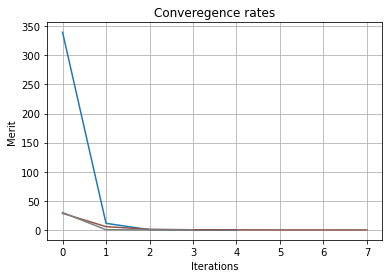

In [5]:
import matplotlib.pyplot as plt

stats = API.get_log(engine)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Converegence rates')
ax.set_xlabel('Iterations')
ax.set_ylabel('Merit')
plt.grid(True)
for i in range(len(stats)):
    data = stats[i]
    if 'residuals' in data.keys():
        residuals = data['residuals']
        reject = data['reject']
        ax.plot( residuals[np.where(reject==False)])
plt.show()